# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

/bin/sh: 1: unzip: not found


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

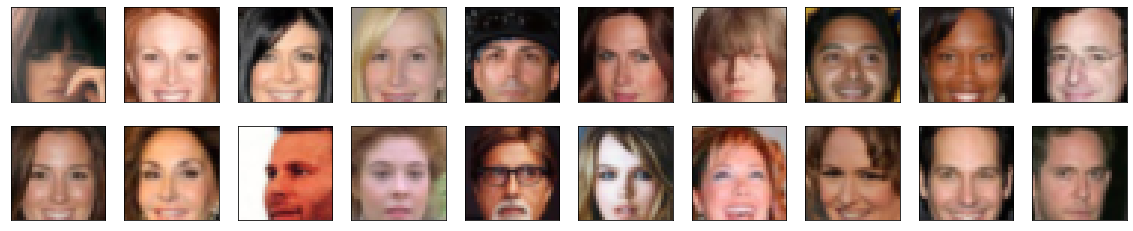

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min = feature_range[0]
    max = feature_range[1]
    range = max - min
    x = x * range + min

    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9529)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
d_dropout = 0.2
d_spectral_norm = True
d_batch_norm = False
d_instance_norm = False

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv_1 = convolution_block(3, conv_dim, batch_norm=False, instance_norm=False)
        self.conv_2 = convolution_block(conv_dim, conv_dim * 2)
        self.conv_3 = convolution_block(conv_dim * 2, conv_dim * 4)
        self.conv_4 = convolution_block(conv_dim * 4, 1, stride=1, padding=0,
            batch_norm=False, instance_norm=False, dropout=None, activation=None)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        
        return x.view(-1, 1)

def convolution_block(in_channels, out_channels, stride=2, padding=1,
                      spectral_norm=d_spectral_norm, batch_norm=d_batch_norm, instance_norm=d_instance_norm,
                      dropout=d_dropout, activation=nn.LeakyReLU(0.2, inplace=True)):
    layers = list()
    conv_layer = nn.Conv2d(
        in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False)
    if spectral_norm:
        conv_layer = nn.utils.spectral_norm(conv_layer)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if activation is not None:
        layers.append(activation)
    if dropout is not None:
        layers.append(nn.Dropout2d(dropout))
    return nn.Sequential(*layers)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
g_dropout = None
g_spectral_norm = True
g_batch_norm = True
g_instance_norm = False
g_final_spectral_norm = True

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        self.deconv_1 = deconvolution_block(z_size, conv_dim * 4, stride=1, padding=0)
        self.deconv_2 = deconvolution_block(conv_dim * 4, conv_dim * 2)
        self.deconv_3 = deconvolution_block(conv_dim * 2, conv_dim)
        self.deconv_4 = deconvolution_block(conv_dim, 3,
            batch_norm=False,
            instance_norm=False,
            dropout=None,
            activation=nn.Tanh())

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = x.view(-1, self.z_size, 1, 1)
        x = self.deconv_1(x)
        x = self.deconv_2(x)
        x = self.deconv_3(x)
        x = self.deconv_4(x)
        
        return x

def deconvolution_block(
        in_channels,
        out_channels,
        stride=2,
        padding=1,
        spectral_norm=g_spectral_norm,
        batch_norm=g_batch_norm,
        instance_norm=g_instance_norm,
        dropout=g_dropout,
        activation=nn.ReLU(inplace=True)):
    layers = list()
    conv_transpose_layer = nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False)
    if spectral_norm:
        conv_transpose_layer = nn.utils.spectral_norm(conv_transpose_layer)
    layers.append(conv_transpose_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(activation)
    if dropout is not None:
        layers.append(nn.Dropout2d(dropout))
    return nn.Sequential(*layers)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(mean=1.0, std=0.02)
        m.bias.data.fill_(0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (conv_4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (deconv_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv_2

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth=None):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    if smooth is not None:
        target = torch.empty_like(D_out).uniform_(smooth[0], smooth[1])
    else:
        target = torch.ones_like(D_out)
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

def fake_loss(D_out, smooth=None):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    if smooth is not None:
        target = torch.empty_like(D_out).uniform_(smooth[0], smooth[1])
    else:
        target = torch.zeros_like(D_out)
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

d_learning_rate = 0.003
g_learning_rate = 0.003
d_beta1 = 0.1
g_beta1 = 0.1

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(d_beta1, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(g_beta1, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
from collections import deque

try:
    import wandb
except ModuleNotFoundError:
    print("wandb not found")
    use_wandb = False
else:
    use_wandb = True

feature_range = (-1.0, 1.0)
label_smoothing_d_real = None
label_smoothing_d_fake = None
z_dist = {"mean": 0.0, "std": 0.5}

def gen_z(sample_num):
    z = torch.empty(sample_num, z_size).normal_(**z_dist)
    if train_on_gpu:
        z = z.cuda()
    return z

def train(D, G, n_epochs, print_every=200):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    d_extra_updates = 0
    g_extra_updates = 0

    if use_wandb:
        wandb.init(project="udacity-dlnd-project-face-generation")
        wandb.config.batch_size = batch_size
        wandb.config.d_conv_dim = d_conv_dim
        wandb.config.g_conv_dim = g_conv_dim
        wandb.config.z_size = z_size
        wandb.config.d_learning_rate = d_learning_rate
        wandb.config.g_learning_rate = g_learning_rate
        wandb.config.d_beta1 = d_beta1
        wandb.config.g_beta1 = g_beta1
        wandb.config.num_epochs = n_epochs
        wandb.config.label_smoothing_d_real = label_smoothing_d_real
        wandb.config.label_smoothing_d_fake = label_smoothing_d_fake
        wandb.config.feature_range = feature_range
        wandb.config.d_dropout = d_dropout
        wandb.config.g_dropout = g_dropout
        wandb.config.z_dist = z_dist
        wandb.config.d_batch_norm = d_batch_norm
        wandb.config.d_spectral_norm = d_spectral_norm
        wandb.config.d_instance_norm = d_instance_norm
        wandb.config.g_batch_norm = g_batch_norm
        wandb.config.g_spectral_norm = g_spectral_norm
        wandb.config.g_instance_norm = g_instance_norm
        wandb.config.d_extra_updates = d_extra_updates
        wandb.config.g_extra_updates = g_extra_updates

    global_batch_i = 0
    step_i = 0
    batch_num = len(celeba_train_loader)
    step_losses_d_real = deque(maxlen=batch_num)
    step_losses_d_fake = deque(maxlen=batch_num)
    step_losses_g = deque(maxlen=batch_num)
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = gen_z(sample_size)

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            real_images = scale(real_images, feature_range)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images

            d_optimizer.zero_grad()

            real_output = D(real_images)
            d_real_loss = real_loss(real_output, smooth=label_smoothing_d_real)
            d_real_loss.backward()

            z = gen_z(batch_size)
            fake_image = G(z)

            fake_output = D(fake_image.detach())
            d_fake_loss = fake_loss(fake_output, smooth=label_smoothing_d_fake)
            d_fake_loss.backward()

            d_loss = d_real_loss + d_fake_loss

            d_optimizer.step()

            step_losses_d_real.append(d_real_loss.item())
            step_losses_d_fake.append(d_fake_loss.item())

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            fake_output = D(fake_image)
            g_loss = real_loss(fake_output)

            step_losses_g.append(g_loss.item())

            g_loss.backward()

            for i in range(g_extra_updates):
                z = gen_z(batch_size)
                image = G(z)
                output = D(image)
                loss = real_loss(output)
                loss.backward()

            g_optimizer.step()

            d_optimizer.zero_grad()
            for i in range(d_extra_updates):
                z = gen_z(batch_size)
                image = G(z)
                output = D(image.detach())
                loss = fake_loss(output)
                loss.backward()

                output = D(real_images)
                loss = real_loss(output)
                loss.backward()
            d_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if global_batch_i % print_every == 0 and global_batch_i > 0:
                step_i += 1

                # append discriminator loss and generator loss
                d_loss = d_loss.item()
                g_loss = g_loss.item()
                losses.append((d_loss, g_loss))

                if use_wandb:
                    avg_loss_d_real = np.mean(list(step_losses_d_real)[-print_every:])
                    avg_loss_d_fake = np.mean(list(step_losses_d_fake)[-print_every:])
                    avg_loss_d = avg_loss_d_real + avg_loss_d_fake
                    avg_loss_g = np.mean(list(step_losses_g)[-print_every:])

                    step_losses_d_real = list()
                    step_losses_d_fake = list()
                    step_losses_g = list()

                    wandb.log({
                        "epoch" : epoch,
                        "d_loss" : d_loss,
                        "d_loss_real" : d_real_loss.item(),
                        "d_loss_fake" : d_fake_loss.item(),
                        "g_loss" : g_loss,
                        "avg_loss_d_real" : avg_loss_d_real,
                        "avg_loss_d_fake" : avg_loss_d_fake,
                        "avg_loss_d" : avg_loss_d,
                        "avg_loss_g" : avg_loss_g,
                    }, step=step_i)

                    G.eval() # for generating samples
                    samples_z = G(fixed_z).detach().cpu().numpy()
                    G.train()

                    images = list()
                    for i in range(sample_size):
                        image = samples_z[i]
                        image = np.transpose(image, (1, 2, 0))
                        image = ((image - feature_range[0]) / (feature_range[1] - feature_range[0]) * 255).astype(np.uint8)
                        images.append(image)
                    wandb.log({
                        "samples" : [wandb.Image(image) for image in images]
                    }, step=step_i)

                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss, g_loss))
            global_batch_i += 1

        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z).detach().cpu().numpy()
        samples.append(samples_z)
        G.train() # back to training mode

        if use_wandb:
            epoch_avg_loss_d_real = np.mean(step_losses_d_real)
            epoch_avg_loss_d_fake = np.mean(step_losses_d_fake)
            epoch_avg_loss_d = epoch_avg_loss_d_real + epoch_avg_loss_d_fake
            epoch_avg_loss_g = np.mean(step_losses_g)

            wandb.log({
                "epoch" : epoch,
                "epoch_avg_loss_d_real": epoch_avg_loss_d_real,
                "epoch_avg_loss_d_fake": epoch_avg_loss_d_fake,
                "epoch_avg_loss_d": epoch_avg_loss_d,
                "epoch_avg_loss_g": epoch_avg_loss_g,
            }, step=step_i)

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 200


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  200] | d_loss: 1.3832 | g_loss: 0.6908
Epoch [    1/  200] | d_loss: 1.2263 | g_loss: 0.6618
Epoch [    1/  200] | d_loss: 1.3803 | g_loss: 0.7148
Epoch [    1/  200] | d_loss: 1.3860 | g_loss: 0.6850
Epoch [    1/  200] | d_loss: 1.3710 | g_loss: 0.7100
Epoch [    1/  200] | d_loss: 1.3868 | g_loss: 0.7090
Epoch [    1/  200] | d_loss: 1.3753 | g_loss: 0.7125
Epoch [    1/  200] | d_loss: 1.3878 | g_loss: 0.7155
Epoch [    1/  200] | d_loss: 1.4105 | g_loss: 0.6965
Epoch [    1/  200] | d_loss: 1.3653 | g_loss: 0.6927
Epoch [    1/  200] | d_loss: 1.3906 | g_loss: 0.7035
Epoch [    1/  200] | d_loss: 1.3600 | g_loss: 0.7031
Epoch [    1/  200] | d_loss: 1.3870 | g_loss: 0.6888
Epoch [    1/  200] | d_loss: 1.3813 | g_loss: 0.6856
Epoch [    2/  200] | d_loss: 1.3855 | g_loss: 0.6823
Epoch [    2/  200] | d_loss: 1.3821 | g_loss: 0.7072
Epoch [    2/  200] | d_loss: 1.3915 | g_loss: 0.6852
Epoch [    2/  200] | d_loss: 1.3849 | g_loss: 0.6897
Epoch [    2/  200] | d_loss

Epoch [   11/  200] | d_loss: 1.3863 | g_loss: 0.6931
Epoch [   11/  200] | d_loss: 1.3864 | g_loss: 0.6928
Epoch [   12/  200] | d_loss: 1.3863 | g_loss: 0.6936
Epoch [   12/  200] | d_loss: 1.3861 | g_loss: 0.6940
Epoch [   12/  200] | d_loss: 1.3863 | g_loss: 0.6936
Epoch [   12/  200] | d_loss: 1.3862 | g_loss: 0.6931
Epoch [   12/  200] | d_loss: 1.3863 | g_loss: 0.6935
Epoch [   12/  200] | d_loss: 1.3863 | g_loss: 0.6930
Epoch [   12/  200] | d_loss: 1.3862 | g_loss: 0.6940
Epoch [   12/  200] | d_loss: 1.3865 | g_loss: 0.6934
Epoch [   12/  200] | d_loss: 1.3862 | g_loss: 0.6932
Epoch [   12/  200] | d_loss: 1.3861 | g_loss: 0.6935
Epoch [   12/  200] | d_loss: 1.3858 | g_loss: 0.6933
Epoch [   12/  200] | d_loss: 1.3863 | g_loss: 0.6928
Epoch [   12/  200] | d_loss: 1.3859 | g_loss: 0.6936
Epoch [   12/  200] | d_loss: 1.3866 | g_loss: 0.6935
Epoch [   13/  200] | d_loss: 1.3863 | g_loss: 0.6930
Epoch [   13/  200] | d_loss: 1.3865 | g_loss: 0.6934
Epoch [   13/  200] | d_loss

Epoch [   22/  200] | d_loss: 1.3856 | g_loss: 0.6911
Epoch [   22/  200] | d_loss: 1.3871 | g_loss: 0.6930
Epoch [   22/  200] | d_loss: 1.3858 | g_loss: 0.6913
Epoch [   22/  200] | d_loss: 1.3864 | g_loss: 0.6936
Epoch [   22/  200] | d_loss: 1.3868 | g_loss: 0.6937
Epoch [   23/  200] | d_loss: 1.3870 | g_loss: 0.6951
Epoch [   23/  200] | d_loss: 1.3851 | g_loss: 0.6905
Epoch [   23/  200] | d_loss: 1.3872 | g_loss: 0.6940
Epoch [   23/  200] | d_loss: 1.3856 | g_loss: 0.6938
Epoch [   23/  200] | d_loss: 1.3860 | g_loss: 0.6931
Epoch [   23/  200] | d_loss: 1.3861 | g_loss: 0.6926
Epoch [   23/  200] | d_loss: 1.3873 | g_loss: 0.6910
Epoch [   23/  200] | d_loss: 1.3849 | g_loss: 0.6888
Epoch [   23/  200] | d_loss: 1.3872 | g_loss: 0.6916
Epoch [   23/  200] | d_loss: 1.3854 | g_loss: 0.6906
Epoch [   23/  200] | d_loss: 1.3875 | g_loss: 0.6933
Epoch [   23/  200] | d_loss: 1.3861 | g_loss: 0.6937
Epoch [   23/  200] | d_loss: 1.3870 | g_loss: 0.6920
Epoch [   23/  200] | d_loss

Epoch [   33/  200] | d_loss: 1.3847 | g_loss: 0.6977
Epoch [   33/  200] | d_loss: 1.3790 | g_loss: 0.6902
Epoch [   33/  200] | d_loss: 1.3838 | g_loss: 0.6874
Epoch [   33/  200] | d_loss: 1.3870 | g_loss: 0.6871
Epoch [   33/  200] | d_loss: 1.3932 | g_loss: 0.6910
Epoch [   33/  200] | d_loss: 1.3873 | g_loss: 0.6890
Epoch [   33/  200] | d_loss: 1.3884 | g_loss: 0.6862
Epoch [   34/  200] | d_loss: 1.3861 | g_loss: 0.6929
Epoch [   34/  200] | d_loss: 1.3881 | g_loss: 0.6937
Epoch [   34/  200] | d_loss: 1.3874 | g_loss: 0.6907
Epoch [   34/  200] | d_loss: 1.3820 | g_loss: 0.6936
Epoch [   34/  200] | d_loss: 1.3875 | g_loss: 0.6978
Epoch [   34/  200] | d_loss: 1.3838 | g_loss: 0.6936
Epoch [   34/  200] | d_loss: 1.3854 | g_loss: 0.6874
Epoch [   34/  200] | d_loss: 1.3873 | g_loss: 0.6847
Epoch [   34/  200] | d_loss: 1.3894 | g_loss: 0.6937
Epoch [   34/  200] | d_loss: 1.3893 | g_loss: 0.6859
Epoch [   34/  200] | d_loss: 1.3868 | g_loss: 0.6908
Epoch [   34/  200] | d_loss

Epoch [   44/  200] | d_loss: 1.3856 | g_loss: 0.6890
Epoch [   44/  200] | d_loss: 1.3847 | g_loss: 0.6925
Epoch [   44/  200] | d_loss: 1.3866 | g_loss: 0.6850
Epoch [   44/  200] | d_loss: 1.3835 | g_loss: 0.6859
Epoch [   44/  200] | d_loss: 1.3896 | g_loss: 0.6870
Epoch [   44/  200] | d_loss: 1.3846 | g_loss: 0.6939
Epoch [   44/  200] | d_loss: 1.3831 | g_loss: 0.6937
Epoch [   44/  200] | d_loss: 1.3848 | g_loss: 0.6857
Epoch [   44/  200] | d_loss: 1.3846 | g_loss: 0.6998
Epoch [   44/  200] | d_loss: 1.3873 | g_loss: 0.6897
Epoch [   45/  200] | d_loss: 1.3877 | g_loss: 0.6926
Epoch [   45/  200] | d_loss: 1.3895 | g_loss: 0.6893
Epoch [   45/  200] | d_loss: 1.3839 | g_loss: 0.6953
Epoch [   45/  200] | d_loss: 1.3890 | g_loss: 0.6954
Epoch [   45/  200] | d_loss: 1.3881 | g_loss: 0.6906
Epoch [   45/  200] | d_loss: 1.3880 | g_loss: 0.6967
Epoch [   45/  200] | d_loss: 1.3844 | g_loss: 0.6972
Epoch [   45/  200] | d_loss: 1.3840 | g_loss: 0.6901
Epoch [   45/  200] | d_loss

wandb: Network error resolved after 0:00:16.372797, resuming normal operation.
wandb: Network error resolved after 0:00:58.527218, resuming normal operation.
wandb: Network error resolved after 0:01:13.989926, resuming normal operation.
Retry attempt failed:
Traceback (most recent call last):
  File "/opt/miniconda/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/miniconda/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/miniconda/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda/lib/python3.7/site-pa

Epoch [   48/  200] | d_loss: 1.3822 | g_loss: 0.6870


wandb: Network error resolved after 0:00:58.286967, resuming normal operation.


Epoch [   48/  200] | d_loss: 1.3894 | g_loss: 0.6830
Epoch [   48/  200] | d_loss: 1.3875 | g_loss: 0.6933
Epoch [   49/  200] | d_loss: 1.3884 | g_loss: 0.6928


requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')")). args: ('https://api.wandb.ai/files/mode89/udacity-dlnd-project-face-generation/8fohytor/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 662, 'content': ['2020-02-03T19:27:36.515215 Epoch [   48/  200] | d_loss: 1.3829 | g_loss: 0.6940\n', '2020-02-03T19:27:47.749155 Epoch [   48/  200] | d_loss: 1.3830 | g_loss: 0.6870\n', '2020-02-03T19:27:59.068594 Epoch [   48/  200] | d_loss: 1.3861 | g_loss: 0.6896\n']}, 'wandb-events.jsonl': {'offset': 298, 'content': ['{"system.gpu.0.gpu": 95.47, "system.gpu.0.memory": 74.53, "system.gpu.0.memoryAllocated": 32.42, "system.gpu.0.temp": 65.0, "system.gpu.0.powerWatts": 120.05, "system.gpu.0.powerPercent": 100.04, "system.cpu": 99.97, "system.memory": 61.3, "system.disk": 66.2, "system.proc.memory.availableMB": 6183.58, "system.proc.memory.rssMB": 1838.14, "system.proc.memory.percent": 11.5, "system.proc.cpu.threads": 3

Epoch [   49/  200] | d_loss: 1.3841 | g_loss: 0.6972
Epoch [   49/  200] | d_loss: 1.3873 | g_loss: 0.6834
Epoch [   49/  200] | d_loss: 1.3836 | g_loss: 0.6864
Epoch [   49/  200] | d_loss: 1.3807 | g_loss: 0.6932
Epoch [   49/  200] | d_loss: 1.3854 | g_loss: 0.6929
Epoch [   49/  200] | d_loss: 1.3786 | g_loss: 0.7054
Epoch [   49/  200] | d_loss: 1.3946 | g_loss: 0.6819
Epoch [   49/  200] | d_loss: 1.3832 | g_loss: 0.6883
Epoch [   49/  200] | d_loss: 1.3821 | g_loss: 0.6891
Epoch [   49/  200] | d_loss: 1.3833 | g_loss: 0.6815
Epoch [   49/  200] | d_loss: 1.3897 | g_loss: 0.6986
Epoch [   49/  200] | d_loss: 1.3877 | g_loss: 0.6979
Epoch [   49/  200] | d_loss: 1.3821 | g_loss: 0.6985
Epoch [   50/  200] | d_loss: 1.3851 | g_loss: 0.6912
Epoch [   50/  200] | d_loss: 1.3814 | g_loss: 0.6985
Epoch [   50/  200] | d_loss: 1.3830 | g_loss: 0.6961
Epoch [   50/  200] | d_loss: 1.3834 | g_loss: 0.6878
Epoch [   50/  200] | d_loss: 1.3817 | g_loss: 0.6994
Epoch [   50/  200] | d_loss

Epoch [   59/  200] | d_loss: 1.3902 | g_loss: 0.6895
Epoch [   59/  200] | d_loss: 1.3822 | g_loss: 0.6851
Epoch [   60/  200] | d_loss: 1.3824 | g_loss: 0.6867
Epoch [   60/  200] | d_loss: 1.3819 | g_loss: 0.6994
Epoch [   60/  200] | d_loss: 1.3846 | g_loss: 0.6851
Epoch [   60/  200] | d_loss: 1.3864 | g_loss: 0.6958
Epoch [   60/  200] | d_loss: 1.3824 | g_loss: 0.6844
Epoch [   60/  200] | d_loss: 1.3837 | g_loss: 0.6816
Epoch [   60/  200] | d_loss: 1.3897 | g_loss: 0.6847
Epoch [   60/  200] | d_loss: 1.3843 | g_loss: 0.6892
Epoch [   60/  200] | d_loss: 1.3810 | g_loss: 0.6845
Epoch [   60/  200] | d_loss: 1.3890 | g_loss: 0.6819
Epoch [   60/  200] | d_loss: 1.3871 | g_loss: 0.6833
Epoch [   60/  200] | d_loss: 1.3832 | g_loss: 0.6829
Epoch [   60/  200] | d_loss: 1.3806 | g_loss: 0.6841
Epoch [   60/  200] | d_loss: 1.3842 | g_loss: 0.6985
Epoch [   61/  200] | d_loss: 1.3857 | g_loss: 0.6844
Epoch [   61/  200] | d_loss: 1.3798 | g_loss: 0.6893
Epoch [   61/  200] | d_loss

Epoch [   70/  200] | d_loss: 1.3774 | g_loss: 0.6925
Epoch [   70/  200] | d_loss: 1.3888 | g_loss: 0.6857
Epoch [   70/  200] | d_loss: 1.3886 | g_loss: 0.6981
Epoch [   70/  200] | d_loss: 1.3890 | g_loss: 0.6956
Epoch [   71/  200] | d_loss: 1.3886 | g_loss: 0.6897
Epoch [   71/  200] | d_loss: 1.3816 | g_loss: 0.6842
Epoch [   71/  200] | d_loss: 1.3865 | g_loss: 0.6944
Epoch [   71/  200] | d_loss: 1.3834 | g_loss: 0.6876
Epoch [   71/  200] | d_loss: 1.3819 | g_loss: 0.6901
Epoch [   71/  200] | d_loss: 1.3823 | g_loss: 0.6805
Epoch [   71/  200] | d_loss: 1.3803 | g_loss: 0.6871
Epoch [   71/  200] | d_loss: 1.3831 | g_loss: 0.6931
Epoch [   71/  200] | d_loss: 1.3875 | g_loss: 0.6948
Epoch [   71/  200] | d_loss: 1.3784 | g_loss: 0.6918
Epoch [   71/  200] | d_loss: 1.3788 | g_loss: 0.6968
Epoch [   71/  200] | d_loss: 1.3822 | g_loss: 0.6859
Epoch [   71/  200] | d_loss: 1.3802 | g_loss: 0.6874
Epoch [   71/  200] | d_loss: 1.3902 | g_loss: 0.6938
Epoch [   72/  200] | d_loss

Epoch [   81/  200] | d_loss: 1.3782 | g_loss: 0.6897
Epoch [   81/  200] | d_loss: 1.3855 | g_loss: 0.6867
Epoch [   81/  200] | d_loss: 1.3789 | g_loss: 0.6896
Epoch [   81/  200] | d_loss: 1.3910 | g_loss: 0.6805
Epoch [   81/  200] | d_loss: 1.3754 | g_loss: 0.7006
Epoch [   81/  200] | d_loss: 1.3737 | g_loss: 0.6801
Epoch [   81/  200] | d_loss: 1.3818 | g_loss: 0.6789
Epoch [   82/  200] | d_loss: 1.3880 | g_loss: 0.6857
Epoch [   82/  200] | d_loss: 1.3840 | g_loss: 0.6833
Epoch [   82/  200] | d_loss: 1.3853 | g_loss: 0.6936
Epoch [   82/  200] | d_loss: 1.3875 | g_loss: 0.6838
Epoch [   82/  200] | d_loss: 1.3862 | g_loss: 0.6964
Epoch [   82/  200] | d_loss: 1.3888 | g_loss: 0.6705
Epoch [   82/  200] | d_loss: 1.3857 | g_loss: 0.7028
Epoch [   82/  200] | d_loss: 1.3813 | g_loss: 0.6917
Epoch [   82/  200] | d_loss: 1.3775 | g_loss: 0.6909
Epoch [   82/  200] | d_loss: 1.3826 | g_loss: 0.6826
Epoch [   82/  200] | d_loss: 1.3770 | g_loss: 0.6827
Epoch [   82/  200] | d_loss

/opt/miniconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch [   92/  200] | d_loss: 1.3807 | g_loss: 0.6906
Epoch [   92/  200] | d_loss: 1.3900 | g_loss: 0.6823
Epoch [   92/  200] | d_loss: 1.3804 | g_loss: 0.6858
Epoch [   92/  200] | d_loss: 1.3927 | g_loss: 0.6857
Epoch [   92/  200] | d_loss: 1.3887 | g_loss: 0.6800
Epoch [   92/  200] | d_loss: 1.3732 | g_loss: 0.6784
Epoch [   92/  200] | d_loss: 1.3859 | g_loss: 0.6829
Epoch [   92/  200] | d_loss: 1.3858 | g_loss: 0.6909
Epoch [   92/  200] | d_loss: 1.3834 | g_loss: 0.6856
Epoch [   92/  200] | d_loss: 1.3769 | g_loss: 0.6838
Epoch [   92/  200] | d_loss: 1.3750 | g_loss: 0.6862
Epoch [   92/  200] | d_loss: 1.3881 | g_loss: 0.6852
Epoch [   92/  200] | d_loss: 1.3855 | g_loss: 0.6890
Epoch [   92/  200] | d_loss: 1.3814 | g_loss: 0.6919
Epoch [   93/  200] | d_loss: 1.3791 | g_loss: 0.6833
Epoch [   93/  200] | d_loss: 1.3851 | g_loss: 0.6900
Epoch [   93/  200] | d_loss: 1.3781 | g_loss: 0.6766
Epoch [   93/  200] | d_loss: 1.3847 | g_loss: 0.6853
Epoch [   93/  200] | d_loss

Epoch [  102/  200] | d_loss: 1.3759 | g_loss: 0.6750
Epoch [  102/  200] | d_loss: 1.3718 | g_loss: 0.6948
Epoch [  103/  200] | d_loss: 1.3865 | g_loss: 0.6896
Epoch [  103/  200] | d_loss: 1.3818 | g_loss: 0.6876
Epoch [  103/  200] | d_loss: 1.3811 | g_loss: 0.6923
Epoch [  103/  200] | d_loss: 1.3809 | g_loss: 0.6907
Epoch [  103/  200] | d_loss: 1.3862 | g_loss: 0.6783
Epoch [  103/  200] | d_loss: 1.3797 | g_loss: 0.6818
Epoch [  103/  200] | d_loss: 1.3852 | g_loss: 0.6913
Epoch [  103/  200] | d_loss: 1.3835 | g_loss: 0.6718
Epoch [  103/  200] | d_loss: 1.3884 | g_loss: 0.6889
Epoch [  103/  200] | d_loss: 1.3862 | g_loss: 0.6984
Epoch [  103/  200] | d_loss: 1.3836 | g_loss: 0.6868
Epoch [  103/  200] | d_loss: 1.3910 | g_loss: 0.6807
Epoch [  103/  200] | d_loss: 1.3784 | g_loss: 0.6844
Epoch [  103/  200] | d_loss: 1.3812 | g_loss: 0.6769
Epoch [  104/  200] | d_loss: 1.3711 | g_loss: 0.6803
Epoch [  104/  200] | d_loss: 1.3895 | g_loss: 0.6683
Epoch [  104/  200] | d_loss

Epoch [  113/  200] | d_loss: 1.3898 | g_loss: 0.6785
Epoch [  113/  200] | d_loss: 1.3886 | g_loss: 0.6818
Epoch [  113/  200] | d_loss: 1.3719 | g_loss: 0.6795
Epoch [  113/  200] | d_loss: 1.3852 | g_loss: 0.6823
Epoch [  113/  200] | d_loss: 1.3816 | g_loss: 0.6962
Epoch [  114/  200] | d_loss: 1.3718 | g_loss: 0.6868
Epoch [  114/  200] | d_loss: 1.3736 | g_loss: 0.6948
Epoch [  114/  200] | d_loss: 1.3814 | g_loss: 0.6873
Epoch [  114/  200] | d_loss: 1.3854 | g_loss: 0.6822
Epoch [  114/  200] | d_loss: 1.3773 | g_loss: 0.6791
Epoch [  114/  200] | d_loss: 1.3802 | g_loss: 0.6828
Epoch [  114/  200] | d_loss: 1.3825 | g_loss: 0.6828
Epoch [  114/  200] | d_loss: 1.3859 | g_loss: 0.6972
Epoch [  114/  200] | d_loss: 1.3776 | g_loss: 0.6862
Epoch [  114/  200] | d_loss: 1.3768 | g_loss: 0.6948
Epoch [  114/  200] | d_loss: 1.3743 | g_loss: 0.6904
Epoch [  114/  200] | d_loss: 1.3793 | g_loss: 0.6802
Epoch [  114/  200] | d_loss: 1.3896 | g_loss: 0.6795
Epoch [  114/  200] | d_loss

Epoch [  124/  200] | d_loss: 1.3828 | g_loss: 0.6893
Epoch [  124/  200] | d_loss: 1.3879 | g_loss: 0.7006
Epoch [  124/  200] | d_loss: 1.3789 | g_loss: 0.6951
Epoch [  124/  200] | d_loss: 1.3783 | g_loss: 0.6986
Epoch [  124/  200] | d_loss: 1.3880 | g_loss: 0.6801
Epoch [  124/  200] | d_loss: 1.3831 | g_loss: 0.6914
Epoch [  124/  200] | d_loss: 1.3841 | g_loss: 0.7006
Epoch [  125/  200] | d_loss: 1.3881 | g_loss: 0.6822
Epoch [  125/  200] | d_loss: 1.3841 | g_loss: 0.6875
Epoch [  125/  200] | d_loss: 1.3690 | g_loss: 0.6850
Epoch [  125/  200] | d_loss: 1.3824 | g_loss: 0.6824
Epoch [  125/  200] | d_loss: 1.3871 | g_loss: 0.6842
Epoch [  125/  200] | d_loss: 1.3836 | g_loss: 0.6811
Epoch [  125/  200] | d_loss: 1.3809 | g_loss: 0.6966
Epoch [  125/  200] | d_loss: 1.3781 | g_loss: 0.6895
Epoch [  125/  200] | d_loss: 1.3878 | g_loss: 0.6818
Epoch [  125/  200] | d_loss: 1.3773 | g_loss: 0.6877
Epoch [  125/  200] | d_loss: 1.3801 | g_loss: 0.6901
Epoch [  125/  200] | d_loss

Epoch [  135/  200] | d_loss: 1.3932 | g_loss: 0.6817
Epoch [  135/  200] | d_loss: 1.3848 | g_loss: 0.6814
Epoch [  135/  200] | d_loss: 1.3845 | g_loss: 0.6827
Epoch [  135/  200] | d_loss: 1.3854 | g_loss: 0.6780
Epoch [  135/  200] | d_loss: 1.3720 | g_loss: 0.6858
Epoch [  135/  200] | d_loss: 1.3800 | g_loss: 0.6870
Epoch [  135/  200] | d_loss: 1.3851 | g_loss: 0.6906
Epoch [  135/  200] | d_loss: 1.3744 | g_loss: 0.6899
Epoch [  135/  200] | d_loss: 1.3829 | g_loss: 0.6821
Epoch [  135/  200] | d_loss: 1.3738 | g_loss: 0.6837
Epoch [  136/  200] | d_loss: 1.3841 | g_loss: 0.6776
Epoch [  136/  200] | d_loss: 1.3758 | g_loss: 0.6920
Epoch [  136/  200] | d_loss: 1.3722 | g_loss: 0.6925
Epoch [  136/  200] | d_loss: 1.3870 | g_loss: 0.6874
Epoch [  136/  200] | d_loss: 1.3816 | g_loss: 0.6816
Epoch [  136/  200] | d_loss: 1.3844 | g_loss: 0.6879
Epoch [  136/  200] | d_loss: 1.3769 | g_loss: 0.6908
Epoch [  136/  200] | d_loss: 1.3859 | g_loss: 0.6890
Epoch [  136/  200] | d_loss

Epoch [  146/  200] | d_loss: 1.3854 | g_loss: 0.6873
Epoch [  146/  200] | d_loss: 1.3873 | g_loss: 0.6844
Epoch [  146/  200] | d_loss: 1.3729 | g_loss: 0.6757
Epoch [  146/  200] | d_loss: 1.3804 | g_loss: 0.6797
Epoch [  146/  200] | d_loss: 1.3853 | g_loss: 0.6840
Epoch [  146/  200] | d_loss: 1.3864 | g_loss: 0.6839
Epoch [  146/  200] | d_loss: 1.3829 | g_loss: 0.6796
Epoch [  146/  200] | d_loss: 1.3883 | g_loss: 0.6771
Epoch [  146/  200] | d_loss: 1.3802 | g_loss: 0.6928
Epoch [  146/  200] | d_loss: 1.3835 | g_loss: 0.6802
Epoch [  146/  200] | d_loss: 1.3784 | g_loss: 0.6818
Epoch [  146/  200] | d_loss: 1.3765 | g_loss: 0.6930
Epoch [  146/  200] | d_loss: 1.3839 | g_loss: 0.6760
Epoch [  147/  200] | d_loss: 1.3835 | g_loss: 0.6955
Epoch [  147/  200] | d_loss: 1.3820 | g_loss: 0.6854
Epoch [  147/  200] | d_loss: 1.3733 | g_loss: 0.6844
Epoch [  147/  200] | d_loss: 1.3780 | g_loss: 0.6817
Epoch [  147/  200] | d_loss: 1.3804 | g_loss: 0.6920
Epoch [  147/  200] | d_loss

Epoch [  156/  200] | d_loss: 1.3814 | g_loss: 0.6816
Epoch [  157/  200] | d_loss: 1.3913 | g_loss: 0.6831
Epoch [  157/  200] | d_loss: 1.3871 | g_loss: 0.6770
Epoch [  157/  200] | d_loss: 1.3832 | g_loss: 0.6839
Epoch [  157/  200] | d_loss: 1.3825 | g_loss: 0.6764
Epoch [  157/  200] | d_loss: 1.3881 | g_loss: 0.6840
Epoch [  157/  200] | d_loss: 1.3877 | g_loss: 0.6912
Epoch [  157/  200] | d_loss: 1.3809 | g_loss: 0.6828
Epoch [  157/  200] | d_loss: 1.3851 | g_loss: 0.6805
Epoch [  157/  200] | d_loss: 1.3859 | g_loss: 0.6759
Epoch [  157/  200] | d_loss: 1.3818 | g_loss: 0.6926
Epoch [  157/  200] | d_loss: 1.3736 | g_loss: 0.6855
Epoch [  157/  200] | d_loss: 1.3827 | g_loss: 0.6769
Epoch [  157/  200] | d_loss: 1.3827 | g_loss: 0.7012
Epoch [  157/  200] | d_loss: 1.3795 | g_loss: 0.6808
Epoch [  158/  200] | d_loss: 1.3785 | g_loss: 0.6901
Epoch [  158/  200] | d_loss: 1.3714 | g_loss: 0.7036
Epoch [  158/  200] | d_loss: 1.3796 | g_loss: 0.6844
Epoch [  158/  200] | d_loss

Epoch [  167/  200] | d_loss: 1.3768 | g_loss: 0.6930
Epoch [  167/  200] | d_loss: 1.3776 | g_loss: 0.6766
Epoch [  167/  200] | d_loss: 1.3768 | g_loss: 0.6925
Epoch [  167/  200] | d_loss: 1.3771 | g_loss: 0.6891
Epoch [  168/  200] | d_loss: 1.3710 | g_loss: 0.6782
Epoch [  168/  200] | d_loss: 1.3759 | g_loss: 0.6857
Epoch [  168/  200] | d_loss: 1.3826 | g_loss: 0.6923
Epoch [  168/  200] | d_loss: 1.3760 | g_loss: 0.6879
Epoch [  168/  200] | d_loss: 1.3776 | g_loss: 0.6890
Epoch [  168/  200] | d_loss: 1.3835 | g_loss: 0.6927
Epoch [  168/  200] | d_loss: 1.3924 | g_loss: 0.6904
Epoch [  168/  200] | d_loss: 1.3841 | g_loss: 0.6887
Epoch [  168/  200] | d_loss: 1.3855 | g_loss: 0.6855
Epoch [  168/  200] | d_loss: 1.3780 | g_loss: 0.6803
Epoch [  168/  200] | d_loss: 1.3798 | g_loss: 0.7003
Epoch [  168/  200] | d_loss: 1.3825 | g_loss: 0.6911
Epoch [  168/  200] | d_loss: 1.3797 | g_loss: 0.6971
Epoch [  168/  200] | d_loss: 1.3839 | g_loss: 0.6868
Epoch [  169/  200] | d_loss

Epoch [  178/  200] | d_loss: 1.3775 | g_loss: 0.6874
Epoch [  178/  200] | d_loss: 1.3879 | g_loss: 0.6892
Epoch [  178/  200] | d_loss: 1.3893 | g_loss: 0.6916
Epoch [  178/  200] | d_loss: 1.3810 | g_loss: 0.6806
Epoch [  178/  200] | d_loss: 1.3879 | g_loss: 0.6779
Epoch [  178/  200] | d_loss: 1.3834 | g_loss: 0.6731
Epoch [  179/  200] | d_loss: 1.3851 | g_loss: 0.6810
Epoch [  179/  200] | d_loss: 1.3807 | g_loss: 0.6889
Epoch [  179/  200] | d_loss: 1.3853 | g_loss: 0.6851
Epoch [  179/  200] | d_loss: 1.3792 | g_loss: 0.6860
Epoch [  179/  200] | d_loss: 1.3838 | g_loss: 0.6786
Epoch [  179/  200] | d_loss: 1.3783 | g_loss: 0.6808
Epoch [  179/  200] | d_loss: 1.3768 | g_loss: 0.6873
Epoch [  179/  200] | d_loss: 1.3828 | g_loss: 0.6826
Epoch [  179/  200] | d_loss: 1.3752 | g_loss: 0.6835
Epoch [  179/  200] | d_loss: 1.3835 | g_loss: 0.6734
Epoch [  179/  200] | d_loss: 1.3876 | g_loss: 0.6779
Epoch [  179/  200] | d_loss: 1.3815 | g_loss: 0.6797
Epoch [  179/  200] | d_loss

Epoch [  189/  200] | d_loss: 1.3788 | g_loss: 0.6837
Epoch [  189/  200] | d_loss: 1.3733 | g_loss: 0.6807
Epoch [  189/  200] | d_loss: 1.3917 | g_loss: 0.6845
Epoch [  189/  200] | d_loss: 1.3932 | g_loss: 0.6819
Epoch [  189/  200] | d_loss: 1.3785 | g_loss: 0.6779
Epoch [  189/  200] | d_loss: 1.3841 | g_loss: 0.6882
Epoch [  189/  200] | d_loss: 1.3893 | g_loss: 0.6878
Epoch [  189/  200] | d_loss: 1.3875 | g_loss: 0.6864
Epoch [  189/  200] | d_loss: 1.3740 | g_loss: 0.6897
Epoch [  190/  200] | d_loss: 1.3785 | g_loss: 0.6842
Epoch [  190/  200] | d_loss: 1.3855 | g_loss: 0.6765
Epoch [  190/  200] | d_loss: 1.3721 | g_loss: 0.6904
Epoch [  190/  200] | d_loss: 1.3767 | g_loss: 0.6844
Epoch [  190/  200] | d_loss: 1.3748 | g_loss: 0.6893
Epoch [  190/  200] | d_loss: 1.3605 | g_loss: 0.6827
Epoch [  190/  200] | d_loss: 1.3874 | g_loss: 0.6777
Epoch [  190/  200] | d_loss: 1.3804 | g_loss: 0.6817
Epoch [  190/  200] | d_loss: 1.3926 | g_loss: 0.6767
Epoch [  190/  200] | d_loss

Epoch [  200/  200] | d_loss: 1.3787 | g_loss: 0.6917
Epoch [  200/  200] | d_loss: 1.3866 | g_loss: 0.6757
Epoch [  200/  200] | d_loss: 1.3839 | g_loss: 0.6740
Epoch [  200/  200] | d_loss: 1.3715 | g_loss: 0.6863
Epoch [  200/  200] | d_loss: 1.3850 | g_loss: 0.6823
Epoch [  200/  200] | d_loss: 1.3833 | g_loss: 0.6811
Epoch [  200/  200] | d_loss: 1.3816 | g_loss: 0.6909
Epoch [  200/  200] | d_loss: 1.3843 | g_loss: 0.6770
Epoch [  200/  200] | d_loss: 1.3739 | g_loss: 0.6970
Epoch [  200/  200] | d_loss: 1.3899 | g_loss: 0.6742
Epoch [  200/  200] | d_loss: 1.3876 | g_loss: 0.6859


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

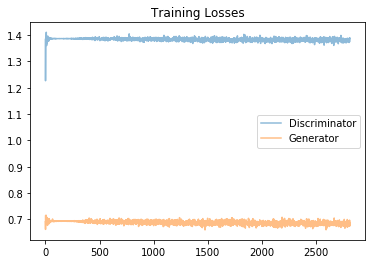

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

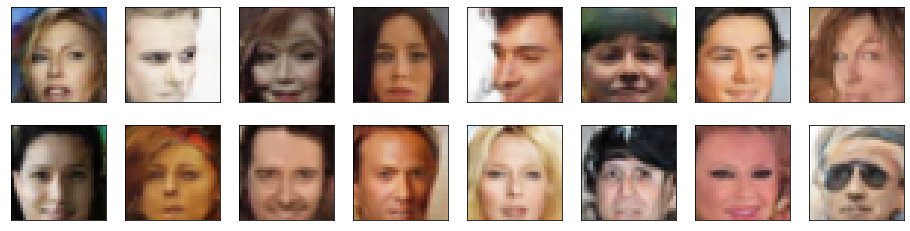

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

The images generated by the trained model represent white people only. I guess, if we append images of random people (not just celebrities), we can improve the ability of the network to generate faces with wider range of skin color.

The original DCGAN paper proposed model with 128 features. I have trained models with 64 and 32 features. The generated images have features resembling people faces, but still there are some artifacts present. Probably, by increasing the number of features, we can get higher fidelity images, because in that case the model will be able to learn more features.

The generator loss is constantly increasing, while the discriminator loss is going down and keep fluctuating around zero. Nevertheless, the quality of generated images is increasing. I speculate, that even though the generator is loosing, its optimizer can still get valuable gradients, because the discriminator has learnt the training dataset well. I think, it would be possible to get even better generated images by training longer.

Pobably, addition of dropout layers may improve interpolation of the underlying distribution.

Since, the loss is fluctuating, I think, it is better to log the averaged loss across many batches, rather then momentary loss. It should help to see the trend of the loss more clearly.

I think, implementation of Progressive GAN can speed up learning and provide higher quility output.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.